 <h1 align="center">Alzheimer's Disease Classification</h1>

 <h3 align="center">Elhai Mansbach & Yosef Sokolov</h3>   

#### Project Overview and Objective:
Alzheimer's disease is a neurological disorder characterized by memory impairment and cognitive decline. It is a leading cause of death and currently has no cure. However, with proper medical treatment, the progression of the disease can be delayed. Automated classification systems can assist medical professionals in diagnosing the stage of Alzheimer's disease and providing appropriate medical interventions. These systems serve as valuable tools to aid in the early detection and management of the disease.

The goal of the project is to develop models for the detection of Alzheimer's disease from MRI brain scans. These models aim to classify whether a subject has Alzheimer's disease based on the patterns identified in the MRI scans associated with Alzheimer's disease. The goal is to train the models to accurately identify these patterns and make predictions about the presence of Alzheimer's disease based on the MRI images.



#### Data-Set Description:
The dataset consists of 6400 MRI brain scans of people with different levels of dementia, divided into train and test sets. 
There are 4 classes of scans: 
1. Non-Demented (3200 scans)
2. Very Mild Demented (2,240 scans)
3. Mild Demented (896 scans)
4. Moderate Demented (64 scans). 



#### Our Techniques: 
1. Traditional machine learning algorithms:
    - SVM
    - KNN
    - Decision Tree
2. Deep Learning:
    - CNN (VGG16)


#### The difficulties and solutions:
1. Images in Different Sizes: The dataset contains images of different sizes. To standardize the input, we convert all the images to have size 176x176, which is the smallest given image size.
2. Imbalanced Data: There is a high imbalance in the data, with a large number of Non-Demented scans and very few Moderate Demented scans.  We address this by using class weights in the Decision Tree and SVM models and data augmentation for the CNN model.
3. ML Models Input Requirement: Machine learning models can only take vectors as input. Since the data contains images represented as 3 matrices (RGB), we convert the images to grayscale (single matrix) and flatten the matrix to a vector by concatenating rows.
4. CNN Training Time: CNN models can be computationally expensive to train. To address this, we use early stopping during CNN training to prevent overfitting and reduce training time.


# Code

## Data Preparation

### Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow   
import keras
import time

import random as rn
import matplotlib.image
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
from distutils.dir_util import remove_tree

from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model



### Set Constants and Seeds


Set seeds for reproducibility 


In [2]:
SEED = 42 
np.random.seed(SEED)
rn.seed(SEED)

Define the paths to the images

In [3]:
FOLDERS     = ['train','test']
DIR_WORK    = 'dataset'
DIR_INPUT   = 'data'
DIR_INPUT_TRAIN = os.path.join(DIR_INPUT,'train')
DIR_INPUT_TEST  = os.path.join(DIR_INPUT,'test')
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASSES  = ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented']
LABELS =dict(zip([0,1,2,3], CLASSES))

Define image size

In [4]:
IMG_SIZE = 176 # this is the minimum dim of the original image size
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

### Data Loading

In [5]:
datagen = ImageDataGenerator(rescale = 1./255,  validation_split=0.1)

In [6]:
data_gen_tr = datagen.flow_from_directory(directory=DIR_INPUT_TRAIN, target_size=DIM, batch_size=6400,shuffle=True,class_mode='categorical')

# get a batch of images
X_train,y_train = data_gen_tr.next()

data_gen_ts = datagen.flow_from_directory(directory=DIR_INPUT_TEST, target_size=DIM, batch_size=6400,shuffle=True,class_mode='categorical')

# get a batch of images
X_test,y_test = data_gen_ts.next()

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [7]:
# Create the train, validation, and test directories if they don't exist
os.makedirs(DIR_TRAIN, exist_ok=True)
os.makedirs(DIR_TEST, exist_ok=True)

# remove existing files/folders
if os.path.exists(DIR_WORK):
    remove_tree(DIR_WORK)
    
os.mkdir(DIR_WORK)

In [8]:
def save_images(images, labels, save_path):
    """
     Function to save images into respective directories based on labels
    @param images: numpy array of images
    @param labels: numpy array of labels
    @param ave_path: path to save images

    """
    for i in range(len(images)):
        image = images[i]
        label = CLASSES[np.argmax(labels[i])]
        image_filename = f"sm_{label}_{i}.jpg"
        label_dir = os.path.join(save_path, str(label))
        os.makedirs(label_dir, exist_ok=True)
        image_path = os.path.join(label_dir, image_filename)
        
        # Save the image with proper data type and file extension
        matplotlib.image.imsave(image_path, image)

save_images(X_test, y_test, DIR_TEST)
save_images(X_train, y_train, DIR_TRAIN)

#### Determine the Number of Images for each class

In [9]:
def images_by_class(dir_path):
    """
    Loop through the path/folders count the number and proportions of each class
    @param dir_path: path to the directory containing the images
    """
        
    # Accumulators
    normal, verymild, mild, moderate = 0, 0, 0, 0
    df =pd.DataFrame(columns=['folder', 'total', 'normal', 'verymild', 'mild', 'moderate', 'normal %', 'verymild %', 'mild %', 'moderate %'])

    for folder in FOLDERS:
        for dirname, _, filenames in os.walk(os.path.join(dir_path, folder)):
            if "NonDemented" in dirname:
                normal += len(filenames)
            elif "VeryMildDemented" in dirname:
                verymild += len(filenames)
            elif 'MildDemented' in dirname:
                mild += len(filenames)
            else:
                moderate += len(filenames)
                    
        # Calculate total and percentages            
        total = normal + verymild + mild + moderate
        if total > 0:
            n = round(normal / total, 2) * 100
            vm = round(verymild / total, 2) * 100
            m = round(mild / total, 2) * 100
            mo = round(moderate / total, 2) * 100
        else:
            n, vm, m, mo = 0, 0, 0, 0
        df.loc[len(df)] = {'folder': folder, 'total': total, 'normal': normal, 'verymild': verymild, 'mild': mild, 'moderate': moderate,'normal %': n, 'verymild %': vm, 'mild %':m, 'moderate %': mo}
        normal, verymild, mild, moderate = 0, 0, 0, 0
    return df


Data-Set Division

In [10]:
# Images by class in the input directory
images_by_class(DIR_INPUT) 


,folder,total,normal,verymild,mild,moderate,normal %,verymild %,mild %,moderate %
0,train,5121,2560,1792,717,52,50.0,35.0,14.0,1.0
1,test,1279,640,448,179,12,50.0,35.0,14.0,1.0


It can be seen that there is an imbalance.

#### Show some images

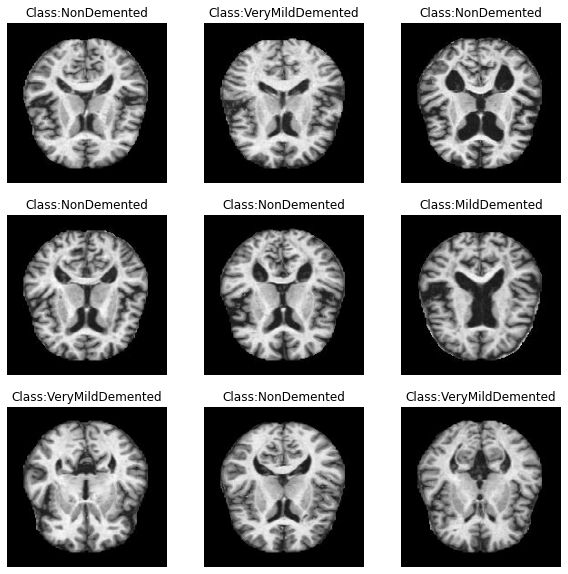

In [11]:
def show_images(X,y):
    """
    Display a grid of 9 images (3 rows, 3 columns) from the generator.
    @param X: images
    @param y: labels
    """
    # get image lables
  
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        idx = randint(0, len(X))
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(LABELS[np.argmax(y[idx])]))
                                                     
X,y = data_gen_tr.next()
show_images(X,y)

## Utils

In [12]:
def statistics(confusion):
    """
    Function to calculate the statistics of the confusion matrix
    @param confusion: confusion matrix
    """
    num_classes = len(CLASSES)

    # Initialize lists for True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN) for each class
    TP = []
    TN = []
    FP = []
    FN = []

    for i in range(num_classes):
        # Calculate True Positives (TP) for class i
        TP_i = confusion[i, i]
        TP.append(TP_i)

        # Calculate True Negatives (TN) for class i
        # Sum of all elements in the confusion matrix except the row and column for class i
        TN_i = np.sum(confusion) - np.sum(confusion[i, :]) - np.sum(confusion[:, i]) + TP_i
        TN.append(TN_i)

        # Calculate False Positives (FP) for class i
        # Sum of column i in the confusion matrix, excluding the true positive count
        FP_i = np.sum(confusion[:, i]) - TP_i
        FP.append(FP_i)

        # Calculate False Negatives (FN) for class i
        # Sum of row i in the confusion matrix, excluding the true positive count
        FN_i = np.sum(confusion[i, :]) - TP_i
        FN.append(FN_i)
    
    print('True Positives (TP):', TP)
    print('True Negatives (TN):', TN)
    print('False Positives (FP):', FP)
    print('False Negatives (FN):', FN)
    
    accuracy = np.sum(TP) / np.sum(confusion)
    print('Classification Accuracy:', accuracy)
    
    precision = np.array(TN) / (np.array(TN) + np.array(FP))
    print('Precision:', precision)
    
    recall = np.array(TP) / (np.array(TP) + np.array(FN))
    print('Recall:', recall)
    
    f_score = 2 * precision * recall / (precision + recall)
    print('F-score:', f_score)

In [13]:
def cm_analysis(y_true, y_pred, labels=CLASSES, figsize=(7, 6)):
    """
    Function to plot the confusion matrix
    @param y_true: true labels
    @param y_pred: predicted labels
    @param labels: list of labels
    @param figsize: size of the figure
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_result = pd.DataFrame(cm, index=labels, columns=labels)
    cm_result.index.name = 'True Label'
    cm_result.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Blues', xticklabels=labels,
                yticklabels=labels)
    plt.show()
    return cm_result, cm


## ML Models

### Data Pre-processing

Convert images to a single vector representation (grayscale)

In [14]:
# Convert images in X_train_img to grayscale
X_train_img_gray = np.array([rgb2gray(img) for img in X_train])

# Convert images in X_test_img to grayscale
X_test_img_gray = np.array([rgb2gray(img) for img in X_test])

In [15]:
X_train_img_gray.shape, X_test_img_gray.shape   

((5121, 176, 176), (1279, 176, 176))

The images were converted from 3d-matrix to 1d-matrix

_














Normalize the grayscale images

In [16]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_img_gray.reshape(len(X_train_img_gray), -1))
X_test_normalized = scaler.transform(X_test_img_gray.reshape(len(X_test_img_gray), -1))

Flatten the normalized images

In [17]:
X_train_img_gray = X_train_normalized.reshape(len(X_train_normalized), -1)
X_test_img_gray = X_test_normalized.reshape(len(X_test_normalized), -1)


# Verify the shape of the flattened data
print("Shape of X_train_flattened:", X_train_img_gray.shape)
print("Shape of X_test_flattened:", X_test_img_gray.shape)

Shape of X_train_flattened: (5121, 30976)
Shape of X_test_flattened: (1279, 30976)


Label Encoding

In [18]:
# Convert y_train to 1-dimensional array
y_train_label = np.argmax(y_train, axis=1)
# Convert y_test to 1-dimensional array
y_test_label = np.argmax(y_test, axis=1)

### Define models


In [19]:
knn = KNeighborsClassifier(weights='distance')
dt = DecisionTreeClassifier(class_weight='balanced',random_state=SEED)
svm = SVC(class_weight='balanced',random_state=SEED)

clfs=[knn,dt,svm] #list of classifiers


### Train & Test Models


Training KNeighborsClassifier(weights='distance')


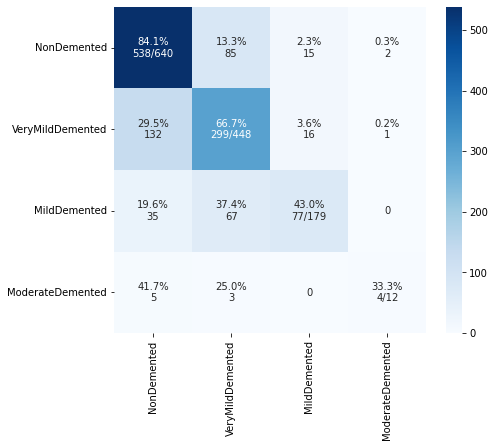

True Positives (TP): [538, 299, 77, 4]
True Negatives (TN): [467, 676, 1069, 1264]
False Positives (FP): [172, 155, 31, 3]
False Negatives (FN): [102, 149, 102, 8]
Classification Accuracy: 0.7177482408131353
Precision: [0.73082942 0.81347774 0.97181818 0.9976322 ]
Recall: [0.840625   0.66741071 0.4301676  0.33333333]
F-score: [0.78189157 0.73324059 0.59636082 0.4997035 ]
                  precision    recall  f1-score   support

     NonDemented       0.76      0.84      0.80       640
VeryMildDemented       0.66      0.67      0.66       448
    MildDemented       0.71      0.43      0.54       179
ModerateDemented       0.57      0.33      0.42        12

        accuracy                           0.72      1279
       macro avg       0.68      0.57      0.60      1279
    weighted avg       0.71      0.72      0.71      1279


Training DecisionTreeClassifier(class_weight='balanced', random_state=42)


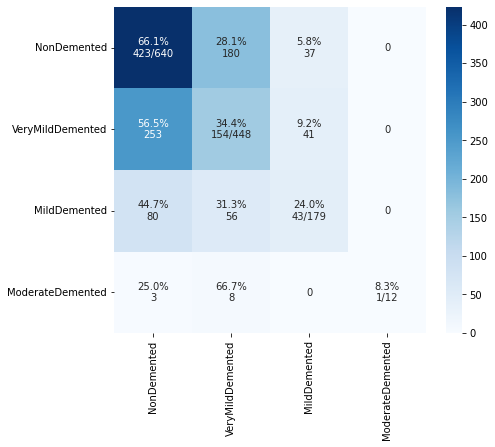

True Positives (TP): [423, 154, 43, 1]
True Negatives (TN): [303, 587, 1022, 1267]
False Positives (FP): [336, 244, 78, 0]
False Negatives (FN): [217, 294, 136, 11]
Classification Accuracy: 0.48553557466770914
Precision: [0.4741784  0.70637786 0.92909091 1.        ]
Recall: [0.6609375  0.34375    0.24022346 0.08333333]
F-score: [0.55219434 0.462453   0.38174411 0.15384615]
                  precision    recall  f1-score   support

     NonDemented       0.56      0.66      0.60       640
VeryMildDemented       0.39      0.34      0.36       448
    MildDemented       0.36      0.24      0.29       179
ModerateDemented       1.00      0.08      0.15        12

        accuracy                           0.49      1279
       macro avg       0.57      0.33      0.35      1279
    weighted avg       0.47      0.49      0.47      1279


Training SVC(class_weight='balanced', random_state=42)


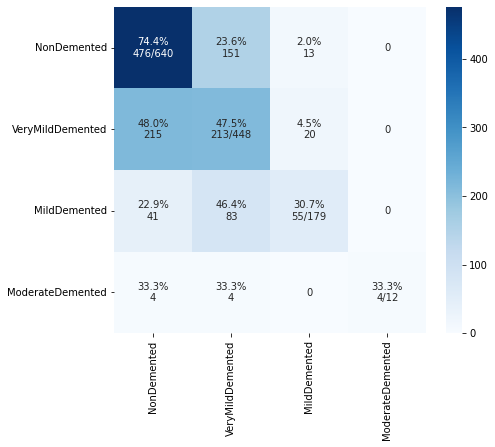

True Positives (TP): [476, 213, 55, 4]
True Negatives (TN): [379, 593, 1067, 1267]
False Positives (FP): [260, 238, 33, 0]
False Negatives (FN): [164, 235, 124, 8]
Classification Accuracy: 0.584831899921814
Precision: [0.59311424 0.71359807 0.97       1.        ]
Recall: [0.74375    0.47544643 0.30726257 0.33333333]
F-score: [0.65994542 0.57067276 0.46669291 0.5       ]
                  precision    recall  f1-score   support

     NonDemented       0.65      0.74      0.69       640
VeryMildDemented       0.47      0.48      0.47       448
    MildDemented       0.62      0.31      0.41       179
ModerateDemented       1.00      0.33      0.50        12

        accuracy                           0.58      1279
       macro avg       0.69      0.46      0.52      1279
    weighted avg       0.59      0.58      0.57      1279



In [20]:
for classifier in clfs:
    print("\nTraining", classifier)
    classifier.fit(X_train_img_gray,y_train_label)
    y_pred = classifier.predict(X_test_img_gray)
    cm_result, cm = cm_analysis(y_test_label, y_pred)
    statistics(cm)
    print(classification_report(y_test_label, y_pred,target_names=CLASSES))



## Deep Learning Model (CNN)

### Data Preprocessing

In [21]:

train_gen = datagen.flow_from_directory(directory=DIR_INPUT_TRAIN,
                                             target_size=DIM,
                                             batch_size=32,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=DIR_INPUT_TRAIN,
                                             target_size=DIM,
                                             batch_size=32,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=DIR_INPUT_TEST,
                                             target_size=DIM,
                                             batch_size=6400,
                                             class_mode='categorical')

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


### VGG16 Model 

#### Define the model

In [22]:

vgg = VGG16(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

#### Training

In [23]:

model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=['acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=50, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/50
145/145 [==============================] - 30s 131ms/step - loss: 0.9032 - acc: 0.6033 - val_loss: 0.8878 - val_acc: 0.5851
Epoch 2/50
145/145 [==============================] - 14s 97ms/step - loss: 0.6730 - acc: 0.7022 - val_loss: 0.8086 - val_acc: 0.6399
Epoch 3/50
145/145 [==============================] - 15s 104ms/step - loss: 0.5563 - acc: 0.7725 - val_loss: 0.7582 - val_acc: 0.6536
Epoch 4/50
145/145 [==============================] - 16s 107ms/step - loss: 0.4675 - acc: 0.8178 - val_loss: 0.7437 - val_acc: 0.6614
Epoch 5/50
145/145 [==============================] - 16s 107ms/step - loss: 0.4414 - acc: 0.8343 - val_loss: 0.6400 - val_acc: 0.7162
Epoch 6/50
145/145 [==============================] - 16s 107ms/step - loss: 0.3951 - acc: 0.8531 - val_loss: 0.6346 - val_acc: 0.7241
Epoch 7/50
145/145 [==============================] - 16s 107ms/step - loss: 0.3553 - acc: 0.8727 - val_loss: 0.7126 - val_acc: 0.6712
Epoch 8/50
145/145 [==============================] - 16

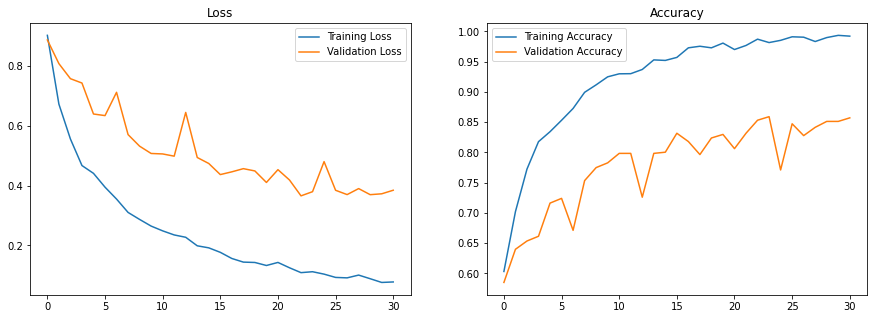

In [24]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    # Loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()
    #plt.show()
    
    # Accuracy
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

plot_metrics(history)

#### Prediction

In [25]:
def prepare_for_test(model, test_gen):
    data, y_true = test_gen.next()
    y_pred_ = model.predict(data, batch_size = 32)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred

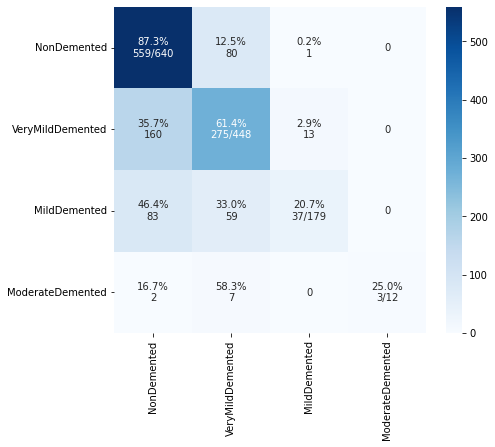

True Positives (TP): [559, 275, 37, 3]
True Negatives (TN): [394, 685, 1086, 1267]
False Positives (FP): [245, 146, 14, 0]
False Negatives (FN): [81, 173, 142, 9]
Classification Accuracy: 0.6833463643471462
Precision: [0.61658842 0.82430806 0.98727273 1.        ]
Recall: [0.8734375  0.61383929 0.20670391 0.25      ]
F-score: [0.72287527 0.70367292 0.34183773 0.4       ]


In [26]:
y_true, y_pred = prepare_for_test(model, test_gen)
cm_result, cm = cm_analysis(y_true, y_pred)
statistics(cm)